### Forward dynamics of `Panda`

In [1]:
import os,glfw
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco_viewer
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.2]


### Parse `Panda`

In [2]:
xml_path='../model/panda/franka_panda.xml'
full_xml_path = os.path.abspath(os.path.join(os.getcwd(),xml_path))
model = mujoco.MjModel.from_xml_path(full_xml_path)
data = mujoco.MjData(model)
print ("[Panda] parsed.")

[Panda] parsed.


In [3]:
n_body          = model.nbody # number of bodies
body_names      = [mujoco.mj_id2name(model,mujoco.mjtObj.mjOBJ_BODY,x) for x in range(n_body)]
n_joint         = model.njnt     # number of joints
joint_names     = [mujoco.mj_id2name(model,mujoco.mjtJoint.mjJNT_HINGE,x) for x in range(n_joint)]
joint_types     = model.jnt_type # joint types
joint_ranges    = model.jnt_range # joint ranges
rev_joint_idxs  = np.where(joint_types==mujoco.mjtJoint.mjJNT_HINGE)[0].astype(np.int32)
rev_joint_names = [joint_names[x] for x in rev_joint_idxs]
n_rev_joint     = len(rev_joint_idxs)
pri_joint_idxs  = np.where(joint_types==mujoco.mjtJoint.mjJNT_SLIDE)[0].astype(np.int32)
pri_joint_names = [joint_names[x] for x in pri_joint_idxs]
n_pri_joint     = len(pri_joint_idxs)
# Print
print ("n_body:[%d]"%(n_body))
print ("body_names:%s"%(body_names))
print ("n_joint:[%d]"%(n_joint))
print ("joint_names:%s"%(joint_names))
print ("joint_types:%s"%(joint_types))
print ("joint_ranges:\n%s"%(joint_ranges))
print ("n_rev_joint:[%d]"%(n_rev_joint))
print ("rev_joint_idxs:%s"%(rev_joint_idxs))
print ("rev_joint_names:%s"%(rev_joint_names))
print ("n_pri_joint:[%d]"%(n_pri_joint))
print ("pri_joint_idxs:%s"%(pri_joint_idxs))
print ("pri_joint_names:%s"%(pri_joint_names))

n_body:[18]
body_names:['world', 'panda_base', 'panda_pedestal', 'panda_link_0', 'panda_link_1', 'panda_link_2', 'panda_link_3', 'panda_link_4', 'panda_link_5', 'panda_link_6', 'panda_link_7', 'right_hand', 'panda_right_gripper', 'panda_eef', 'panda_leftfinger', 'panda_finger_joint1_tip', 'panda_rightfinger', 'panda_finger_joint2_tip']
n_joint:[9]
joint_names:['panda_joint1', 'panda_joint2', 'panda_joint3', 'panda_joint4', 'panda_joint5', 'panda_joint6', 'panda_joint7', 'panda_finger_joint1', 'panda_finger_joint2']
joint_types:[3 3 3 3 3 3 3 2 2]
joint_ranges:
[[-2.9   2.9 ]
 [-1.76  1.76]
 [-2.9   2.9 ]
 [-3.07 -0.07]
 [-2.9   2.9 ]
 [-0.02  3.75]
 [-2.9   2.9 ]
 [ 0.    0.04]
 [-0.04  0.  ]]
n_rev_joint:[7]
rev_joint_idxs:[0 1 2 3 4 5 6]
rev_joint_names:['panda_joint1', 'panda_joint2', 'panda_joint3', 'panda_joint4', 'panda_joint5', 'panda_joint6', 'panda_joint7']
n_pri_joint:[2]
pri_joint_idxs:[7 8]
pri_joint_names:['panda_finger_joint1', 'panda_finger_joint2']


### Free-fal motion (press `ESC` to stop)

In [4]:
dt = model.opt.timestep
nstep = 5 # how many steps we take per 'mj_step'

In [5]:
# Viewer
viewer = mujoco_viewer.MujocoViewer(model,data,mode='window',
    title='Panda in MuJoCo',width=1200,height=800,hide_menus=True)
viewer.cam.azimuth   = 80
viewer.cam.distance  = 4.0
viewer.cam.elevation = -30
viewer.cam.lookat = np.array([0,0,1.2])
# simulate and render
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)
# Buffers
tick = 0
times,qrevs,imgs,img_times = [],[],[],[]
max_time = 4 # (second)
while data.time < max_time:
    tick = tick + 1
    if viewer.is_alive:
        data.actuator_force[0] = 1.0
        mujoco.mj_step(model,data,nstep=nstep)
        viewer.render()
    else: break # terminate if viewer is dead
    # Append time and position
    times.append(data.time)
    qrevs.append(data.qpos[rev_joint_idxs])
    # Plot and append current rendered secne
    every_second = 0.5
    if (tick % int(every_second/dt/nstep)) == 0: # every second
        # Grab image
        img = np.zeros((viewer.viewport.height,viewer.viewport.width,3),dtype=np.uint8)
        mujoco.mjr_render(viewer.viewport, viewer.scn, viewer.ctx)
        mujoco.mjr_readPixels(img, None, viewer.viewport, viewer.ctx) # this makes a little delay
        img = np.flipud(img) # flip image
        # Append image
        imgs.append(img)
        img_times.append(data.time)
# close viewer
viewer.close() # do we need this? yes

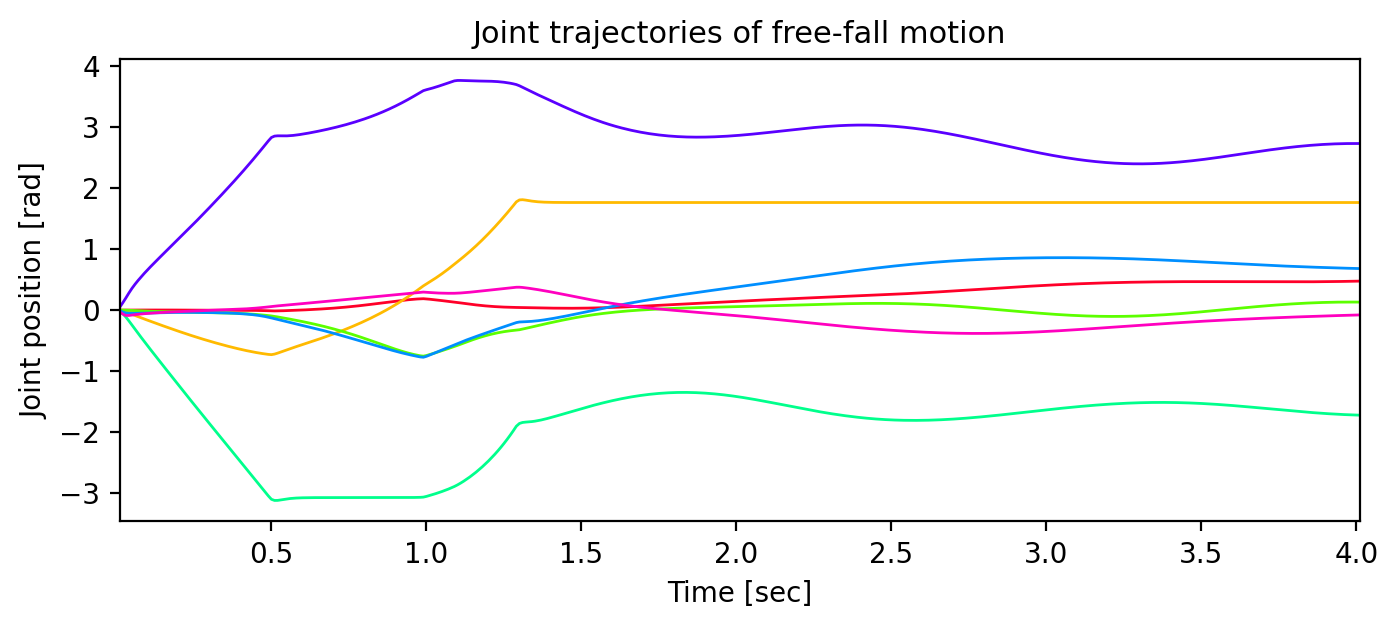

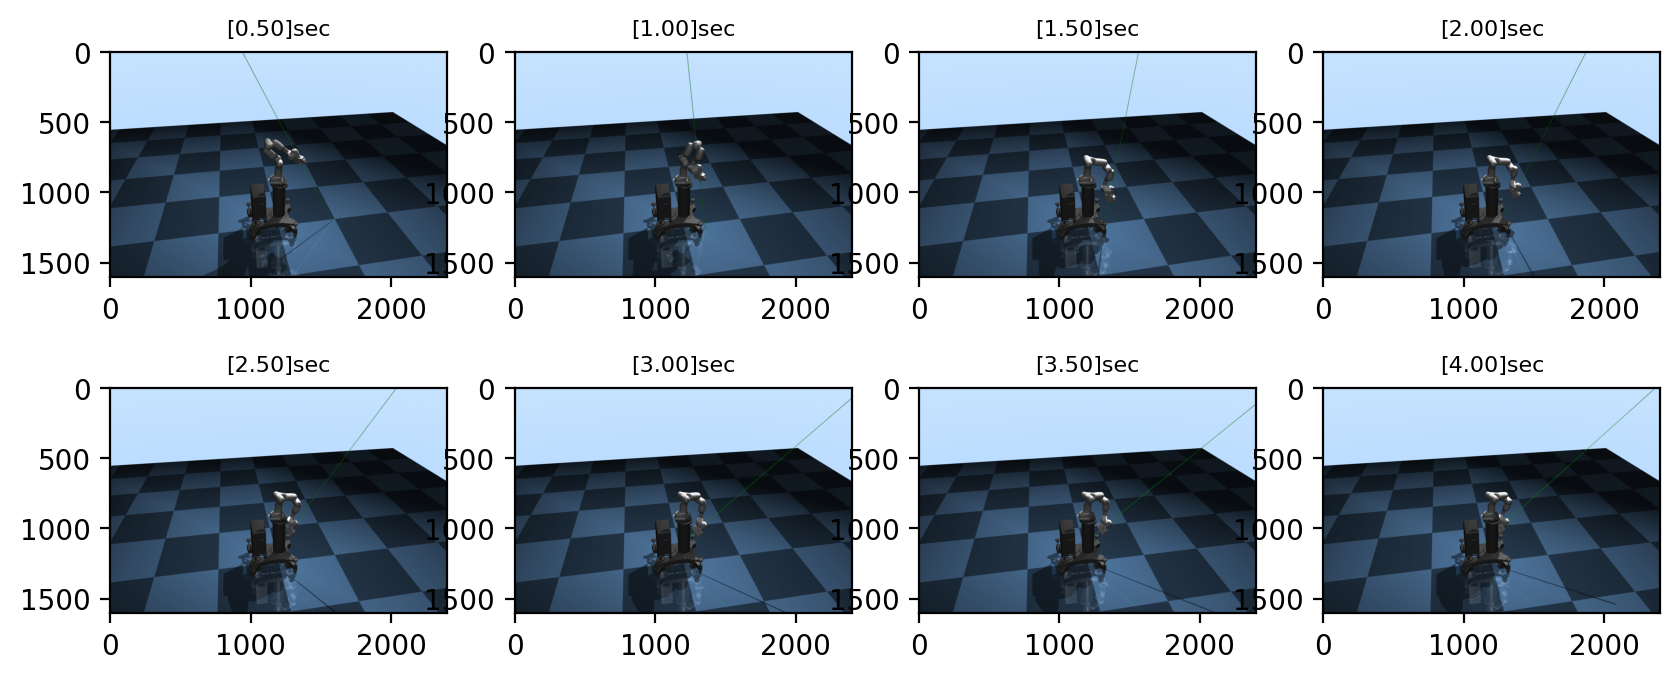

In [6]:
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_rev_joint)]
plt.figure(figsize=(8,3))
for j_idx in range(n_rev_joint):
    plt.plot(np.array(times),np.array(qrevs)[:,j_idx],ls='-',color=cs[j_idx],lw=1)
plt.title('Joint trajectories of free-fall motion',fontsize=11)
plt.xlim(times[0],times[-1])
plt.xlabel('Time [sec]',fontsize=10)
plt.ylabel('Joint position [rad]',fontsize=10)
plt.show()

# Plot snapshots for Panda with FK
fig = plt.figure(figsize=(10,4))
for i_idx,img in enumerate(imgs):
    ax = fig.add_subplot(2,4,i_idx+1)
    ax.imshow(img)
    ax.set_title('[%.2f]sec'%(img_times[i_idx]),fontsize=8)

### Apply external force on a body of `Panda`

In [7]:
# Viewer
viewer = mujoco_viewer.MujocoViewer(model,data,mode='window',
    title='Panda in MuJoCo',width=1200,height=800,hide_menus=True)
viewer.cam.azimuth   = 80
viewer.cam.distance  = 4.0
viewer.cam.elevation = -30
viewer.cam.lookat = np.array([0,0,1.2])
# simulate and render
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)
# Buffers
tick = 0
times,qrevs,imgs,img_times = [],[],[],[]
max_time = 4 # (second)
while data.time < max_time:
    tick = tick + 1
    if viewer.is_alive:
        # Step with applying external force
        body_name = 'panda_eef'
        data.body(body_name).xfrc_applied = np.array([0,0,100,0,0,0])
        mujoco.mj_step(model,data,nstep=nstep)
        # Add marker
        viewer.add_marker(
            pos   = data.body(body_name).xpos,
            size  = [0.05,0.05,0.05],
            rgba  = [1,0,0,0.3],
            type  = mujoco.mjtGeom.mjGEOM_SPHERE,
            label = 'EE')
        # Render
        viewer.render()
    else: break # terminate if viewer is dead
    # Append time and position
    times.append(data.time)
    qrevs.append(data.qpos[rev_joint_idxs])
    # Plot and append current rendered secne
    every_second = 0.5
    if (tick % int(every_second/dt/nstep)) == 0: # every second
        # Grab image
        img = np.zeros((viewer.viewport.height,viewer.viewport.width,3),dtype=np.uint8)
        mujoco.mjr_render(viewer.viewport, viewer.scn, viewer.ctx)
        mujoco.mjr_readPixels(img, None, viewer.viewport, viewer.ctx) # this makes a little delay
        img = np.flipud(img) # flip image
        # Append image
        imgs.append(img)
        img_times.append(data.time)
# close viewer
viewer.close()

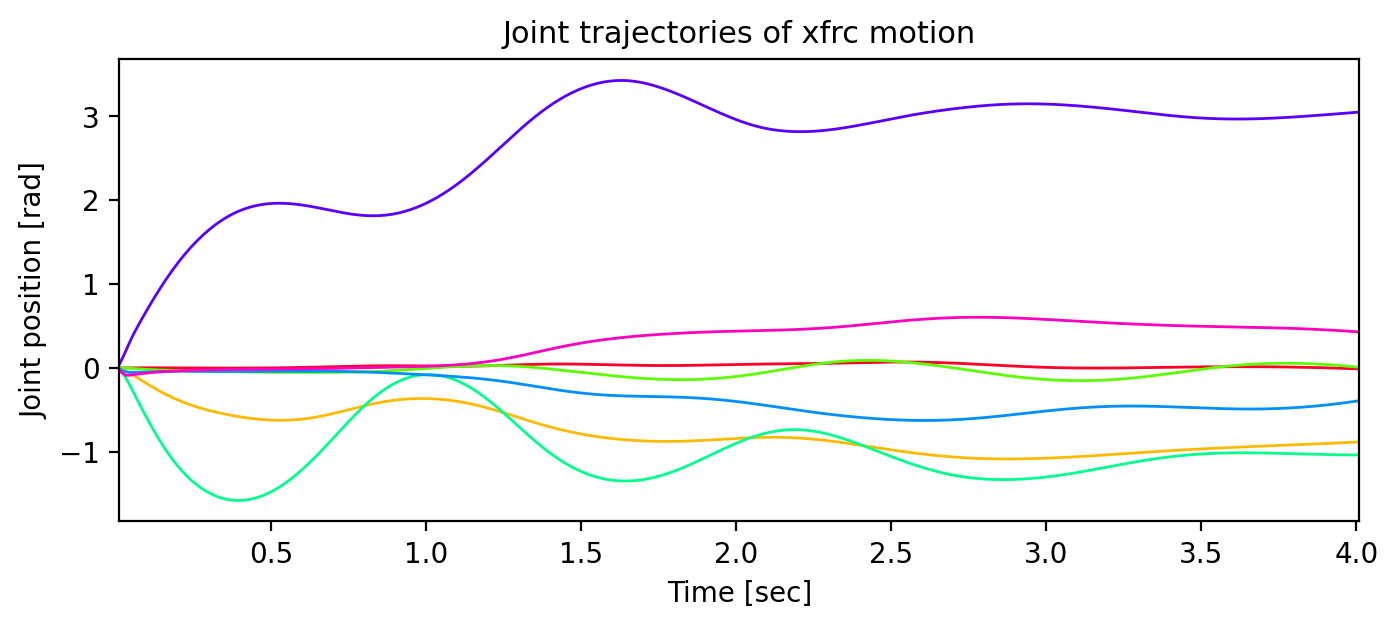

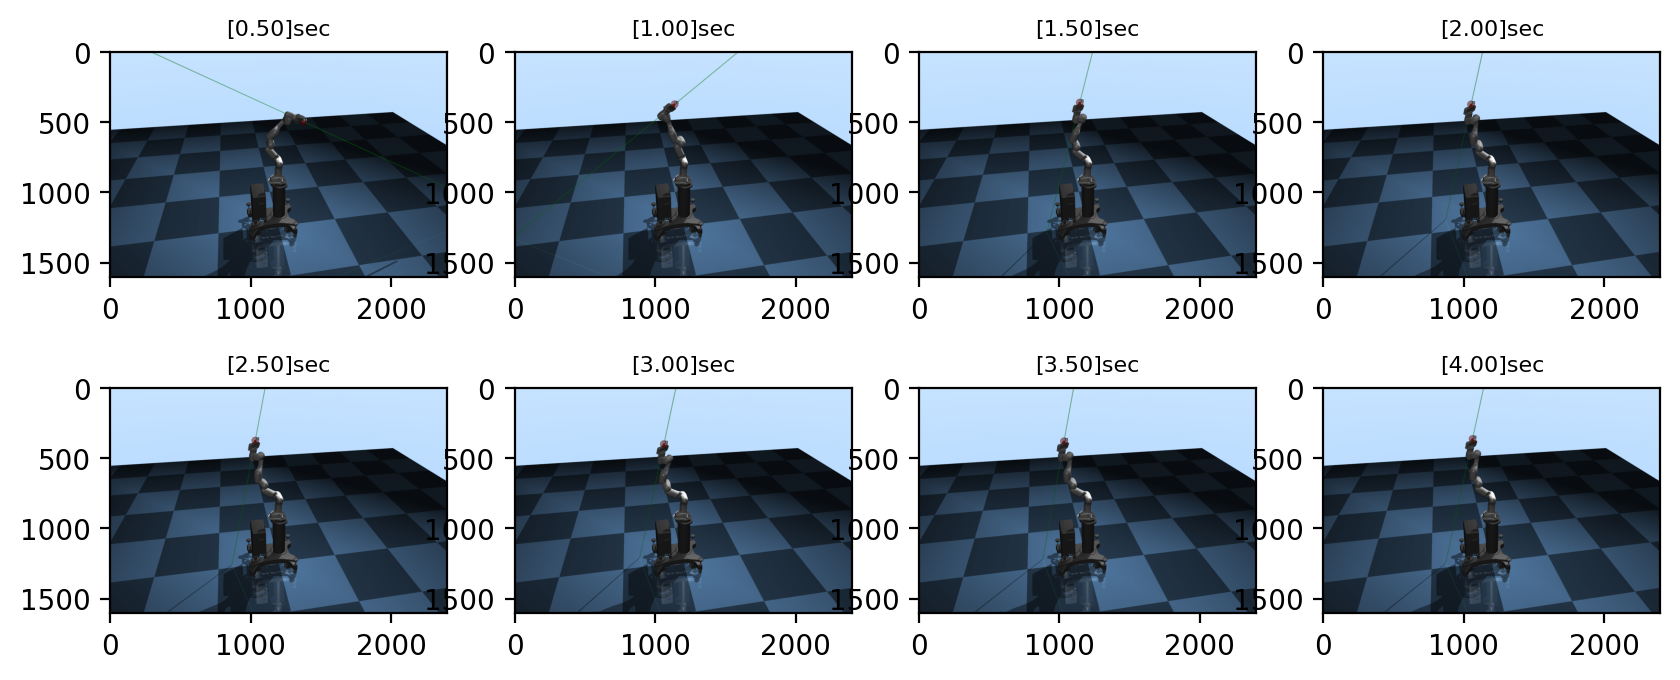

In [8]:
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_rev_joint)]
plt.figure(figsize=(8,3))
for j_idx in range(n_rev_joint):
    plt.plot(np.array(times),np.array(qrevs)[:,j_idx],ls='-',color=cs[j_idx],lw=1)
plt.title('Joint trajectories of xfrc motion',fontsize=11)
plt.xlim(times[0],times[-1])
plt.xlabel('Time [sec]',fontsize=10)
plt.ylabel('Joint position [rad]',fontsize=10)
plt.show()

# Plot snapshots for Panda with FK
fig = plt.figure(figsize=(10,4))
for i_idx,img in enumerate(imgs):
    ax = fig.add_subplot(2,4,i_idx+1)
    ax.imshow(img)
    ax.set_title('[%.2f]sec'%(img_times[i_idx]),fontsize=8)